**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [4]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [5]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(coordinates[1])
print(coordinates[2])

print('gfjkhgfjhgfkgh')
print(coordinates[3])
print(coordinates[4])
print(coordinates[5])

print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
[ 0.         -0.71017975  0.50340914]
[ 0.         -0.0037242  -0.06630491]
gfjkhgfjhgfkgh
[0.         0.77715107 0.59586089]
[ 0.         -0.77642641  0.59515778]
[ 0.000000e+00 -4.529000e-05 -7.443867e-02]
-13815.2523726009


In [6]:
print(coordinates)

[[ 0.          0.769767    0.55746937]
 [ 0.         -0.71017975  0.50340914]
 [ 0.         -0.0037242  -0.06630491]
 ...
 [ 0.          0.81441381  0.59863567]
 [ 0.         -0.76145415  0.54978922]
 [ 0.         -0.00330998 -0.07177656]]


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [7]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

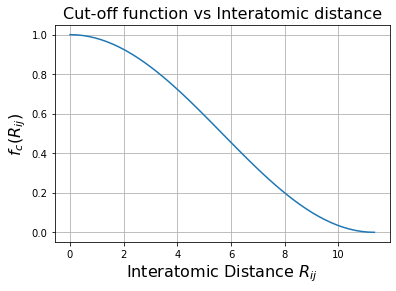

In [8]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [9]:
i = 0                                # i-th water molecule
coord = coordinates[3*i:3*(i+1),:]   # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom

def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    N = len(coord)
    pairwise_dist_matrix = np.zeros((N,N))       # Initialise the matrix
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]

    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [10]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [11]:
lambdaa = 1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[i,:] - coord[k,:]
                    cos_theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * cos_theta_ijk )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.19473151 5.24520024 5.28298916]


In [12]:
np.cos(180)

-0.5984600690578581

**<h2>Training and Test Set**

In [13]:
N                    = 3           # number of atoms per molecule
number_of_features   = 6           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

    
    
# heta   = np.linspace(0.01, 4, num=number_of_features)
# random.shuffle(heta)

# Rs     = np.linspace(0, 1, num=number_of_features)
# random.shuffle(Rs)

# lambdaa = np.ones(number_of_features)
# random.shuffle(lambdaa)

# zeta    = np.linspace(0, 8, num=number_of_features)
# random.shuffle(zeta)


heta    = [0.01,  4.,    3.202, 1.606, 2.404, 0.808] 
zeta    = [8.,  1.6, 3.2, 4.8, 6.4, 0. ]
Rs      = [0.8, 0.4, 0.2, 1.,  0.,  0.6]
lambdaa = [1., 1., 1., 1., 1., 1.]







data_size            = np.shape(energies)[0]        # We have 1000 water molecule conformations
training_set_size    = data_size - 100



    
G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])     
        G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]):
    for j in range(np.shape(G)[1]):
        G[i,j] = (G[i,j]-mean[j])/var[j]   


data_set = np.vsplit(G,data_size)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])

labels = energies          # turning energies into a (1000) tensor


# Computing variance and mean on the training data only!
lab_train = labels[:training_set_size]
var_lab  = np.var(lab_train,axis=0)
mean_lab = np.mean(lab_train,axis=0)
print(mean_lab)

labelss = np.zeros((np.shape(labels)))
# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(labels)[0]):
    labelss[i] = (labels[i]-mean_lab)/var_lab  
    
    
labelss = torch.FloatTensor(labelss)      
    
    
# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labelss[:training_set_size]
test_labels          = labelss[training_set_size:]

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25,
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

-13813.419735561924
torch.Size([900, 3, 6])


In [14]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [15]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(6, 3)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3,train = True):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0) 
#        x = self.fc_out(x)
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([ -29.2808,    1.3305,   -9.2254, -144.8022,  -13.5390,  -43.2955])
x2 tensor([-16.4986,   0.6675,  -0.0754,  74.7737,  -0.4341,  16.6143])
x3 tensor([ 85.2207,  -2.0988,  16.9244, 191.8523,  25.0267,  65.6689])
output
tensor([-0.0143], grad_fn=<ViewBackward>)


In [16]:
# class simplenn(nn.Module):
#     def __init__(self):
#         super(simplenn, self).__init__()
#         self.fc1 = nn.Linear(2, 3)        # where fc stands for fully connected 
#         self.fc2 = nn.Linear(3, 1)        
   

#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
#         x = self.fc2(x)                   # Using a linear function (identity function) for the subnet output layers
#         return x

# mod = simplenn()

# print(mod.fc1.weight)
# print(mod.fc1.bias)

# print(mod.fc2.weight)
# print(mod.fc2.bias)

In [17]:
# x1, x2, x3 = training_set[0]
# x1 = x1[:2]
# x2 = x2[:2]

# x1[0] = -18650
# x1[1] = 109075
# print('x1',x1)

# x2[0] = -6
# x2[1] = 7
# print('x2',x2)

# output1 = mod(x1)
# print('output1')
# print(output1)

# output2 = mod(x2)
# print('output2')
# print(output2)

In [18]:
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)

x1 tensor([ -29.2808,    1.3305,   -9.2254, -144.8022,  -13.5390,  -43.2955])
x2 tensor([-16.4986,   0.6675,  -0.0754,  74.7737,  -0.4341,  16.6143])
x3 tensor([ 85.2207,  -2.0988,  16.9244, 191.8523,  25.0267,  65.6689])
output
tensor([-0.0143], grad_fn=<ViewBackward>)


In [19]:
## Manually compute neural Network output

# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [20]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.1589, -0.2502,  0.2748,  0.3607, -0.2570, -0.0059],
        [ 0.2620,  0.3297, -0.2469,  0.3697,  0.2121,  0.3243],
        [ 0.1323,  0.2603,  0.0840, -0.2077, -0.3135,  0.1061]],
       requires_grad=True)
biases
Parameter containing:
tensor([-0.3242, -0.1442, -0.3936], requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[-0.1456,  0.1234, -0.4108],
        [ 0.3078,  0.2989,  0.4993],
        [ 0.1977,  0.3343, -0.3881]], requires_grad=True)
biases
Parameter containing:
tensor([ 0.3793, -0.2828, -0.4646], requires_grad=True)


**<h2>Training the Neural Network**

In [21]:
net = BPNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
#torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 100

train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = torch.zeros(np.shape(inputs)[0])
        # forward + backward + optimize
        for j in range(np.shape(inputs)[0]):
            outputs[j] = net(inputs[j][0],inputs[j][1],inputs[j][2])        #??????????????????????????????????????
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()
        
        
        net_test_set = torch.zeros(np.shape(test_set)[0])
        with torch.no_grad():
            for k in range(np.shape(test_set)[0]):
                   net_test_set[k] = net(test_set[j][0],test_set[j][1],test_set[j][2])
            epoch_test_loss += criterion(net_test_set, test_labels).item()
        if i % 100 == 0:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, loss))
            running_loss = 0.0
        counter += 1
    
    train_loss[epoch] = epoch_train_loss/counter
    test_loss[epoch] = epoch_test_loss/counter
    epoch_train_loss = 0.0

print('Finished Training')

[1,     1] loss: 1.53215
[2,     1] loss: 0.04168
[3,     1] loss: 0.04429
[4,     1] loss: 0.04196
[5,     1] loss: 0.04111
[6,     1] loss: 0.05609
[7,     1] loss: 0.03674
[8,     1] loss: 0.03561
[9,     1] loss: 0.02875
[10,     1] loss: 0.02634
[11,     1] loss: 0.02444
[12,     1] loss: 0.02157
[13,     1] loss: 0.02146
[14,     1] loss: 0.01612
[15,     1] loss: 0.03354
[16,     1] loss: 0.02588
[17,     1] loss: 0.02020
[18,     1] loss: 0.03385
[19,     1] loss: 0.01687
[20,     1] loss: 0.03260
[21,     1] loss: 0.02434
[22,     1] loss: 0.02056
[23,     1] loss: 0.02259
[24,     1] loss: 0.02248
[25,     1] loss: 0.02861
[26,     1] loss: 0.03283
[27,     1] loss: 0.03709
[28,     1] loss: 0.01693
[29,     1] loss: 0.02925
[30,     1] loss: 0.02908
[31,     1] loss: 0.02699
[32,     1] loss: 0.01130
[33,     1] loss: 0.01967
[34,     1] loss: 0.01785
[35,     1] loss: 0.01559
[36,     1] loss: 0.02659
[37,     1] loss: 0.01334
[38,     1] loss: 0.03609
[39,     1] loss: 0.0

In [112]:

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 20

train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = torch.zeros(np.shape(inputs)[0])
        # forward + backward + optimize
        for j in range(np.shape(inputs)[0]):
            outputs[j] = net(inputs[j][0],inputs[j][1],inputs[j][2])        #??????????????????????????????????????
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()
        
        
        net_test_set = torch.zeros(np.shape(test_set)[0])
        with torch.no_grad():
            for k in range(np.shape(test_set)[0]):
                   net_test_set[k] = net(test_set[j][0],test_set[j][1],test_set[j][2])
            epoch_test_loss += criterion(net_test_set, test_labels).item()
            
        if i % 100 == 0:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, loss))
            running_loss = 0.0
        counter += 1
    
    train_loss[epoch] = epoch_train_loss/counter
    test_loss[epoch] = epoch_test_loss/counter
    epoch_train_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.00101
[2,     1] loss: 0.00073
[3,     1] loss: 0.00174
[4,     1] loss: 0.00094
[5,     1] loss: 0.00150
[6,     1] loss: 0.00141
[7,     1] loss: 0.00113
[8,     1] loss: 0.00096
[9,     1] loss: 0.00090
[10,     1] loss: 0.00087
[11,     1] loss: 0.00087
[12,     1] loss: 0.00086
[13,     1] loss: 0.00086
[14,     1] loss: 0.00086
[15,     1] loss: 0.00086
[16,     1] loss: 0.00086
[17,     1] loss: 0.00086
[18,     1] loss: 0.00085
[19,     1] loss: 0.00085
[20,     1] loss: 0.00085
Finished Training


In [113]:
print(np.shape(outputs))

torch.Size([25])


In [114]:
x1, x2, x3 = test_set[10]
x1 = x1
print(x1)

output = net(x1, x2, x3)
print('output')
print(output)

tensor([ -47.1594,    1.0143,   -9.9748, -152.5495,  -14.7487,  -46.0137])
output
tensor([-0.4905], grad_fn=<ViewBackward>)


In [115]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]


In [116]:
print(prediction)


[-0.38379806 -0.43183175 -0.10768666 -0.28911862 -0.2933954  -0.09560608
  0.17479777  0.11391863  0.0398407   0.11770698 -0.49049217 -0.37092209
 -0.18214896 -0.35842845 -0.44311005  0.07066074 -0.10281181  0.08601776
 -0.11643607 -0.52850407  0.45209542  0.0333339  -0.14941321  0.04122972
 -0.44853851 -0.02435797 -0.41270384  0.12020537 -0.2843695   0.17217353
  0.42027435  0.35376528  0.48059544 -0.32955629 -0.04051489 -0.36901096
 -0.38726965 -0.17070675  0.17966032 -0.40893677 -0.0494225  -0.46546578
  0.70486772 -0.14960983 -0.25169581  0.37484911 -0.24284348  0.02676223
 -0.06676103  0.10369098  0.0813157  -0.17234126 -0.17612308 -0.20321867
 -0.05150425 -0.01047748 -0.44716352  0.27940097 -0.18933389 -0.47698048
  0.05532885 -0.22397476  0.31280631 -0.50147969 -0.04566525  0.09360004
 -0.14956683  0.44207636  0.77607536 -0.30541712 -0.1053791   0.05604938
  0.2744872   0.6012578   0.57477689  0.10893726 -0.0654364   0.02171183
 -0.39857978 -0.39718673 -0.02273622 -0.29920617  0

In [117]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))


(900,)
-2.6490954e-09


In [118]:
print(mean_lab)

-13813.419735561924


tensor(-0.5770, dtype=torch.float64)


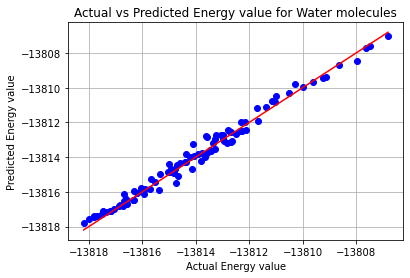

In [119]:
prediction = torch.tensor(prediction)

x = np.linspace(min(test_labels*var_lab+mean_lab), max(test_labels*var_lab+mean_lab))
print(min(torch.cat((test_labels,prediction),0)))
y = x
plt.plot(test_labels*var_lab+mean_lab,prediction*var_lab+mean_lab, 'o', color='blue')
plt.plot(x,y, color='red')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.xlabel('Actual Energy value')
plt.ylabel('Predicted Energy value')
plt.title('Actual vs Predicted Energy value for Water molecules')

plt.show()


In [111]:
print(type(prediction))

<class 'torch.Tensor'>


In [85]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.2217, -0.7113,  1.3080, -0.2968,  0.9527,  0.3063],
        [-0.2508,  0.4203, -0.2437, -0.1268, -0.1178, -0.0207],
        [ 0.2447,  0.8685, -1.4775,  0.0635, -1.6685,  0.3466]],
       requires_grad=True)
biases
Parameter containing:
tensor([-0.6076,  0.3954,  1.7372], requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[-0.3801,  0.1915, -0.3088],
        [ 0.0222, -0.3973, -0.1179],
        [-0.2653,  0.1705,  0.4331]], requires_grad=True)
biases
Parameter containing:
tensor([-0.4189,  0.7103, -0.0386], requires_grad=True)


In [32]:
heta    = [0.01,  4.,    3.202, 1.606, 2.404, 0.808] 
zeta    = [8.,  1.6, 3.2, 4.8, 6.4, 0. ]
Rs      = [0.8, 0.4, 0.2, 1.,  0.,  0.6]
lambdaa = [1., 1., 1., 1., 1., 1.]